# 불량품 예측

불량품을 예측하기 위해 다음과 같은 함수화 정리를 진행한다. 혼란을 막기 위해 모든 과정을 함수화 하기로 한다.  
목차는 다음과 같다.

- 1. Load packages & Data
- 2. Function

## 1. Load Packages & Data

In [199]:
### ide packages
import os
from pprint import pprint
import numpy as np
import pandas as pd
import random
import string
from tqdm import tqdm

# sklearn preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    precision_recall_curve,
    recall_score,
    silhouette_score,
)

# models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_metric
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.cluster import KMeans

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px

# tuning
import optuna

In [200]:
# load data
load_dir = './data/'
train = pd.read_csv(load_dir + "train.csv")
test = pd.read_csv(load_dir + "test.csv")

## 2. Functions

In [201]:
# 평가 스코어 지정하기
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

# 평가 매트릭 계산 결과 보여주기
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [202]:
# 해당 공정 맞춤형 위치 옮기기
def move_data(data):
    # divide
    dam = data.filter(regex='_Dam')
    fill1 = data.filter(regex='_Fill1')
    fill2 = data.filter(regex='_Fill2')
    autoclave = data.filter(regex='_AutoClave')
    target = data['target']

    # dam
    dam = dam.dropna(axis=1, how='all')
    dam = dam.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
    dam_mask = dam[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
    dam = dam.drop(columns='WorkMode Collect Result_Dam')

    # fill1
    fill1 = fill1.dropna(axis=1, how='all')
    fill1 = fill1.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
    fill1_mask = fill1[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
    fill1.loc[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1.columns[14:]] = fill1_mask
    fill1 = fill1.drop(columns='WorkMode Collect Result_Fill1')

    # fill2
    fill2 = fill2.dropna(axis=1, how='all')
    fill2 = fill2.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
    fill2_mask = fill2[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
    fill2 = fill2.drop(columns='WorkMode Collect Result_Fill2')

    # CONCAT
    data = pd.concat([dam, fill1, fill2, autoclave, target], axis=1)
    
    return data

In [203]:
# 칼럼 위치 변경
def swap_columns(df, condition, col1, col2):
    # 조건에 해당하는 행 필터링
    filtered_df = df[condition]
    
    # 값 교환
    df.loc[condition, [col1, col2]] = filtered_df[[col1, col2]].copy().iloc[:, ::-1].values

    return df

In [204]:
# Equipment 방향 통일과 잘못된 위치 재조정하기
def change_data(train, test):
    # train
    train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    X_sum_down_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_down_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    X_sum_up_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_up_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    X_sum_down = (X_sum_down_1 - X_sum_down_2) / 2 # stage1에서 빼고, Stage3에서 더하기 <500
    X_sum_up = (X_sum_up_2 - X_sum_up_1) / 2 # stage1에서 더하고, Stage 3에서 빼기

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # test
    test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # train
    Y_sum_dam_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']

    Y_sum_dam_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']

    Y_sum_dam_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']

    Y_sum_fill_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']

    Y_sum_fill_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    Y_sum_fill_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']

    # test
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')


    ### Test
    # 조건을 만족하는 행 인덱스를 찾음
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')
    
    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')
    
    ### Train
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    return train, test

In [205]:
# Dam, Fill1, Fill2에서 지정된 값이 다를 경우 Abnormal 
def inconsistant(data, columnname, iwantthiscolumnsname, is_train = True):
    # 장비 번호가 다르면 불일치
    if is_train:
        cri = [
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill1'],
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill2'],
            df_train[columnname + '_Fill1'] != df_train[columnname + '_Fill2'],
            data[iwantthiscolumnsname] == 1
        ]
        
    else:
        cri = [
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill1'],
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill2'],
            df_test[columnname + '_Fill1'] != df_test[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
    con = [1, 1, 1, 1]

    data[iwantthiscolumnsname] = np.select(cri, con, default = 0)

In [206]:
# 변수 세팅
def variable_setting(types, tr, te, columns_to_convert, columns_to):
    train = tr.copy()
    test = te.copy()
    
    if types == 'catboost':
        dtype = 'string'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'lightgbm':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'xgboost':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    return train, test

In [207]:
def model_best_threshold(model, X_valid, y_valid):
    # Precision - Recall
    y_pred_proba = model.predict_proba(X_valid)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
    f1_scores = 2*recall*precision / (recall + precision)
    cat_best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
    
    return thresholds, y_pred_custom_threshold

In [208]:
def xgboost_optuna(train, cat_features_indices):
    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        }

        model = XGBClassifier(eval_metric='logloss', **params, early_stopping_rounds = 50, enable_categorical=True)

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

        # 검증 세트에 대한 예측 및 평가
        preds = model.predict_proba(X_valid)[:, 1]

        # thresholds
        precision, recall, thresholds = precision_recall_curve(y_valid_cat_last, cat_proba)
        f1_scores = 2*recall*precision / (recall + precision)
        cat_best_threshold = thresholds[np.argmax(f1_scores)]
        y_pred_custom_threshold_cat = (cat_proba >= cat_best_threshold).astype(int)

        f1 = f1_score(y_valid, y_pred_custom_threshold_cat)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

In [209]:
def lightgbm_optuna(train, cat_features_indices):

    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    def objective(trial):
        lgbm_params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 1500),
            "max_depth": trial.suggest_int('max_depth', 3, 63),
            "learning_rate": trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True), 
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            "min_child_weight": trial.suggest_float('min_child_weight', 0.5, 4),
            "min_child_samples": trial.suggest_int('min_child_samples', 5, 100),
            "subsample": trial.suggest_float('subsample', 0.4, 1),
            "subsample_freq": trial.suggest_int('subsample_freq', 0, 5),
            "colsample_bytree": trial.suggest_float('colsample_bytree', 0.2, 1),
            'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        }

        model = LGBMClassifier(**lgbm_params, device='cpu', random_state=42, verbose=-1)

        # 범주형 피처 적용
        model.fit(X_train, y_train, categorical_feature=cat_features_indices,
            eval_set = [(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
            ]
        )

        # 검증 세트에 대한 예측 및 평가
        preds = model.predict_proba(X_valid)[:, 1]

        # thresholds
        precision, recall, thresholds = precision_recall_curve(y_valid_cat_last, cat_proba)
        f1_scores = 2*recall*precision / (recall + precision)
        cat_best_threshold = thresholds[np.argmax(f1_scores)]
        y_pred_custom_threshold_cat = (cat_proba >= cat_best_threshold).astype(int)

        f1 = f1_score(y_valid, y_pred_custom_threshold_cat)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

In [210]:
def catboost_optuna(train, cat_features_indices):
    
    # train X, y
    X = train.drop(columns=['target'])
    y = train['target']

    # $plit 
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Pooling
    train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)
    
    # tuning parameters
    def objective(trial):
        # 하이퍼파라미터를 샘플링
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            "od_wait": trial.suggest_int("od_wait", 10, 50),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#             "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
            "verbose": 0,
            "random_seed": 42
        }

        # CatBoost 모델 학습
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)

        # 검증 세트에 대한 예측 및 평가
        preds = model.predict_proba(X_valid)[:, 1]

        # thresholds
        precision, recall, thresholds = precision_recall_curve(y_valid_cat_last, cat_proba)
        f1_scores = 2*recall*precision / (recall + precision)
        cat_best_threshold = thresholds[np.argmax(f1_scores)]
        y_pred_custom_threshold_cat = (cat_proba >= cat_best_threshold).astype(int)

        f1 = f1_score(y_valid, y_pred_custom_threshold_cat)
        
        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

## 3. Setting

In [211]:
# inconsistant 열 이름
columnname = [
    'Equipment', 
    'Receip No Collect Result', 
    'Production Qty Collect Result', 
    'PalletID Collect Result'
]

In [212]:
# 최종 선택할 행 이름
sel_col = [
    'Model.Suffix_Dam',
    'Workorder_Dam',
    'CURE SPEED Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Machine Tact time Collect Result_Dam',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam',
    'THICKNESS 1 Collect Result_Dam', 
    'THICKNESS 2 Collect Result_Dam',
    'THICKNESS 3 Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
    'Head Purge Position Z Collect Result_Fill1',
    'Machine Tact time Collect Result_Fill1',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE SPEED Collect Result_Fill2',
    'CURE START POSITION Z Collect Result_Fill2',
    'Machine Tact time Collect Result_Fill2',
    '1st Pressure Collect Result_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '3rd Pressure Collect Result_AutoClave',
    'Chamber Temp. Collect Result_AutoClave',
    'inconsistant',
    'Stage1 Line diffent Distance Speed_Dam',
    'Stage2 Line diffent Distance Speed_Dam',
    'Stage3 Line diffent Distance Speed_Dam',
    'PalletID Collect Result_Dam',
    'Receip No Collect Result_Dam',
    'Equipment_Dam',
    'kmeans_5',
    'round_1st_time',
    'round_2nd_time',
    'round_3rd_time',
    'all_time',
    'RESIN Adjusted_Predicted_Volume Stage1 Dam',
    'RESIN Adjusted_Predicted_Volume Stage2 Dam',
    'RESIN Adjusted_Predicted_Volume Stage3 Dam',
    'RESIN Adjusted_Predicted_Volume Stage1 Fill1',
    'RESIN Adjusted_Predicted_Volume Stage2 Fill1',
    'RESIN Adjusted_Predicted_Volume Stage3 Fill1',
    'target'
]

## 4. Matched Data

In [213]:
# 위치 옮기기
train_move = move_data(train)
test_move = move_data(test)

/tmp/ipykernel_378/691509256.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.     0.012  0.     0.     0.     0.     0.     0.    -0.054  0.     0.    -0.054 -0.054  0.     0.014  0.     0.     0.     0.     0.    -0.054  0.014  0.     0.    -0.015  0.     0.     0.014  0.014  0.     0.    -0.019  0.     0.     0.     0.     0.     0.014 -0.054  0.     0.014  0.     0.     0.    -0.019 -0.019  0.     0.     0.     0.     0.    -0.019  0.     0.     0.     0.     0.     0.     0.     0.014  0.     0.    -0.015  0.     0.     0.    -0.015  0.     0.     0.014  0.     0.     0.    -0.054  0.     0.     0.     0.014  0.     0.     0.    -0.054  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.012  0.     0.     0.     0.     0.     0.014  0.     0.     0.     0.    -0.019  0.     0.     0.    -0.015  0.     0.     0.     0.    -0.054  0.     0.     0.     0.     0.     0.  

In [214]:
# 위치 변경 및 Equipment2 를 Equipment1 방향으로 변경
df_train, df_test = change_data(train_move, test_move)

### Type Change

In [215]:
# 데이터 타입 변경하기
type_change = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
]

for i in type_change:
    df_train[i] = df_train[i].astype('float64')
    df_test[i] = df_test[i].astype('float64')

### Modified Equipment data type

In [216]:
# Equipment 번호만 가져오기
df_train['Equipment_Dam'] = df_train['Equipment_Dam'].str.slice(15, 16)
df_train['Equipment_Fill1'] = df_train['Equipment_Fill1'].str.slice(17, 18)
df_train['Equipment_Fill2'] = df_train['Equipment_Fill2'].str.slice(17, 18)

df_test['Equipment_Dam'] = df_test['Equipment_Dam'].str.slice(15, 16)
df_test['Equipment_Fill1'] = df_test['Equipment_Fill1'].str.slice(17, 18)
df_test['Equipment_Fill2'] = df_test['Equipment_Fill2'].str.slice(17, 18)

### New Column

In [217]:
# 불일치 변수
df_train['inconsistant'] = 0
df_test['inconsistant'] = 0

# 장착
for i in columnname:
    inconsistant(df_train, i, 'inconsistant', True)
    inconsistant(df_test, i, 'inconsistant', False)

In [218]:
# 시간이 0이하, 900이상인 값은 이상치로 분류
for j in ['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']:
    cri = [
        df_train[j] <= 0,
        df_train[j] > 900
    ]
    cri2 = [
        df_test[j] <= 0,
        df_test[j] > 900
    ]
    con = [
        1, 1
    ]
    df_train['inconsistant'] = np.select(cri, con, default = df_train['inconsistant'])
    df_test['inconsistant'] = np.select(cri2, con, default = df_test['inconsistant'])

### Speed Line & Circle

In [219]:
# 라인별로 속도가 같아야 정상이다.
df_train['Stage1 Line diffent Distance Speed_Dam'] = ((df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage1 Line Sum Speed_Dam'] = df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line4 Distance Speed Collect Result_Dam']

df_train['Stage2 Line diffent Distance Speed_Dam'] = ((df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage2 Line Sum Speed_Dam'] = df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line4 Distance Speed Collect Result_Dam']

df_train['Stage3 Line diffent Distance Speed_Dam'] = ((df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage3 Line Sum Speed_Dam'] = df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line4 Distance Speed Collect Result_Dam']


In [220]:
# 라인별로 속도가 같아야 정상이다.
df_test['Stage1 Line diffent Distance Speed_Dam'] = ((df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage1 Line Sum Speed_Dam'] = df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line4 Distance Speed Collect Result_Dam']

df_test['Stage2 Line diffent Distance Speed_Dam'] = ((df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage2 Line Sum Speed_Dam'] = df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line4 Distance Speed Collect Result_Dam']

df_test['Stage3 Line diffent Distance Speed_Dam'] = ((df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage3 Line Sum Speed_Dam'] = df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line4 Distance Speed Collect Result_Dam']

### Cure differenciates

In [221]:
# 경화 x 좌표 dam
df_train['cure_x_dist_dam'] = df_train['CURE START POSITION X Collect Result_Dam'] - df_train['CURE END POSITION X Collect Result_Dam']
df_test['cure_x_dist_dam'] = df_test['CURE START POSITION X Collect Result_Dam'] - df_test['CURE END POSITION X Collect Result_Dam']

In [222]:
# 경화 z좌표 dam
df_train['cure_z_dist_dam'] = df_train['CURE START POSITION Z Collect Result_Dam'] - df_train['CURE END POSITION Z Collect Result_Dam']
df_test['cure_z_dist_dam'] = df_test['CURE START POSITION Z Collect Result_Dam'] - df_test['CURE END POSITION Z Collect Result_Dam']

In [223]:
# 경화 z좌표 fill2
df_train['cure_z_dist_fill2'] = df_train['CURE START POSITION Z Collect Result_Fill2'] - df_train['CURE END POSITION Z Collect Result_Fill2']
df_test['cure_z_dist_fill2'] = df_test['CURE START POSITION Z Collect Result_Fill2'] - df_test['CURE END POSITION Z Collect Result_Fill2']

### time 보정

In [224]:
# time 보정하기
df_train['round_1st_time'] = round(df_train['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_train['round_2nd_time'] = round(df_train['2nd Pressure Unit Time_AutoClave'], -1)
df_train['round_3rd_time'] = round(df_train['3rd Pressure Unit Time_AutoClave'], -1)
df_train['all_time'] = round(df_train['Chamber Temp. Unit Time_AutoClave'], -1)

df_test['round_1st_time'] = round(df_test['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_test['round_2nd_time'] = round(df_test['2nd Pressure Unit Time_AutoClave'], -1)
df_test['round_3rd_time'] = round(df_test['3rd Pressure Unit Time_AutoClave'], -1)
df_test['all_time'] = round(df_test['Chamber Temp. Unit Time_AutoClave'], -1)

time_col = [
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Unit Time_AutoClave',
    'Chamber Temp. Unit Time_AutoClave'
]

# 적용
df_train = df_train.drop(columns = time_col, axis = 1)
df_test = df_test.drop(columns = time_col, axis = 1)

### K-means cluster

In [225]:
cluster_col = [
    'CURE SPEED Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
    'Dispense Volume(Stage1) Collect Result_Dam',
    'Dispense Volume(Stage2) Collect Result_Dam',
    'Dispense Volume(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Machine Tact time Collect Result_Dam', 
    'PalletID Collect Result_Dam',
    'Production Qty Collect Result_Dam',
    'Receip No Collect Result_Dam',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam',
    'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam',
    'THICKNESS 3 Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
    'Dispense Volume(Stage1) Collect Result_Fill1',
    'Dispense Volume(Stage2) Collect Result_Fill1',
    'Dispense Volume(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
    'Head Purge Position Z Collect Result_Fill1',
    'CURE SPEED Collect Result_Fill2', 'inconsistant', 'cure_x_dist_dam',
    'cure_z_dist_dam', 'cure_z_dist_fill2'
]

In [226]:
# kmeans에 사용할 칼럼만 불러오기
use_train = df_train[cluster_col]
use_test = df_test[cluster_col]

In [227]:
# # 실루엣 분석을 사용하여 최적의 K값 탐색
# silhouette_scores = []
# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(use_train)
#     score = silhouette_score(use_train, kmeans.labels_)
#     silhouette_scores.append(score)

# # 실루엣 분석 그래프 그리기
# plt.plot(range(2, 11), silhouette_scores, marker='o')

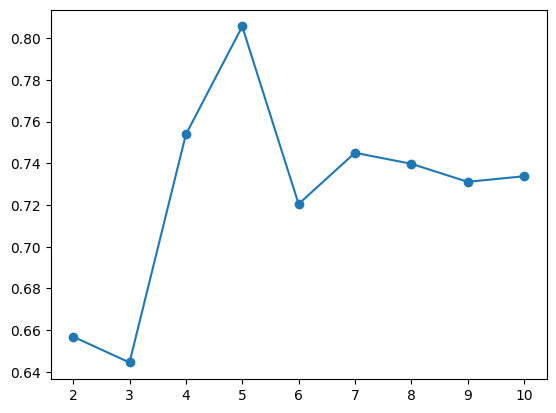

In [228]:
# parameters
best_k = 5 # centroid의 best 개수 -> elbow, 실루엣 두 방법을 비교하여 선정한다.
abnormal = 1 # 시뮬레이션에서 이상치 판독 기준 개수

# Best k 적합하기
best = KMeans(
        n_clusters = best_k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42
    ).fit(use_train)

In [229]:
df_train['kmeans_5'] = best.labels_

In [230]:
df_test['kmeans_5'] = best.predict(use_test)

### 각 Stage별 새로운 Resin 값을 제시하기 위한 코드

In [231]:
## train
# Stage별 토출량, 토출 속도, 토출 소요시간 데이터
df_train['RESIN Predicted_Volume Stage1 Dam'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
df_train['RESIN Predicted_Volume Stage2 Dam'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
df_train['RESIN Predicted_Volume Stage3 Dam'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

# Stage별 실제 토출량과 예측 토출량의 비율(조정 계수) 계산
df_train['Stage1 Scaling_Factor'] = df_train['Dispense Volume(Stage1) Collect Result_Dam'] / df_train['RESIN Predicted_Volume Stage1 Dam']
df_train['Stage2 Scaling_Factor'] = df_train['Dispense Volume(Stage2) Collect Result_Dam'] / df_train['RESIN Predicted_Volume Stage2 Dam']
df_train['Stage3 Scaling_Factor'] = df_train['Dispense Volume(Stage3) Collect Result_Dam'] / df_train['RESIN Predicted_Volume Stage3 Dam']

# Stage별 조정된 예측 토출량 계산
df_train['RESIN Adjusted_Predicted_Volume Stage1 Dam'] = df_train['RESIN Predicted_Volume Stage1 Dam'] * df_train['Stage1 Scaling_Factor'].mean()
df_train['RESIN Adjusted_Predicted_Volume Stage2 Dam'] = df_train['RESIN Predicted_Volume Stage2 Dam'] * df_train['Stage2 Scaling_Factor'].mean()
df_train['RESIN Adjusted_Predicted_Volume Stage3 Dam'] = df_train['RESIN Predicted_Volume Stage3 Dam'] * df_train['Stage3 Scaling_Factor'].mean()

## test
# Stage별 토출량, 토출 속도, 토출 소요시간 데이터
df_test['RESIN Predicted_Volume Stage1 Dam'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
df_test['RESIN Predicted_Volume Stage2 Dam'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
df_test['RESIN Predicted_Volume Stage3 Dam'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

# Stage별 실제 토출량과 예측 토출량의 비율(조정 계수) 계산
df_test['Stage1 Scaling_Factor'] = df_test['Dispense Volume(Stage1) Collect Result_Dam'] / df_test['RESIN Predicted_Volume Stage1 Dam']
df_test['Stage2 Scaling_Factor'] = df_test['Dispense Volume(Stage2) Collect Result_Dam'] / df_test['RESIN Predicted_Volume Stage2 Dam']
df_test['Stage3 Scaling_Factor'] = df_test['Dispense Volume(Stage3) Collect Result_Dam'] / df_test['RESIN Predicted_Volume Stage3 Dam']

# Stage별 조정된 예측 토출량 계산
df_test['RESIN Adjusted_Predicted_Volume Stage1 Dam'] = df_test['RESIN Predicted_Volume Stage1 Dam'] * df_test['Stage1 Scaling_Factor'].mean()
df_test['RESIN Adjusted_Predicted_Volume Stage2 Dam'] = df_test['RESIN Predicted_Volume Stage2 Dam'] * df_test['Stage2 Scaling_Factor'].mean()
df_test['RESIN Adjusted_Predicted_Volume Stage3 Dam'] = df_test['RESIN Predicted_Volume Stage3 Dam'] * df_test['Stage3 Scaling_Factor'].mean()

In [232]:
## train
# Stage별 토출량, 토출 속도, 토출 소요시간 데이터
df_train['RESIN Predicted_Volume Stage1 Fill1'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_train['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
df_train['RESIN Predicted_Volume Stage2 Fill1'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_train['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
df_train['RESIN Predicted_Volume Stage3 Fill1'] = df_train['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_train['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

# Stage별 실제 토출량과 예측 토출량의 비율(조정 계수) 계산
df_train['Stage1 Scaling_Factor'] = df_train['Dispense Volume(Stage1) Collect Result_Fill1'] / df_train['RESIN Predicted_Volume Stage1 Fill1']
df_train['Stage2 Scaling_Factor'] = df_train['Dispense Volume(Stage2) Collect Result_Fill1'] / df_train['RESIN Predicted_Volume Stage2 Fill1']
df_train['Stage3 Scaling_Factor'] = df_train['Dispense Volume(Stage3) Collect Result_Fill1'] / df_train['RESIN Predicted_Volume Stage3 Fill1']

# Stage별 조정된 예측 토출량 계산
df_train['RESIN Adjusted_Predicted_Volume Stage1 Fill1'] = df_train['RESIN Predicted_Volume Stage1 Fill1'] * df_train['Stage1 Scaling_Factor'].mean()
df_train['RESIN Adjusted_Predicted_Volume Stage2 Fill1'] = df_train['RESIN Predicted_Volume Stage2 Fill1'] * df_train['Stage2 Scaling_Factor'].mean()
df_train['RESIN Adjusted_Predicted_Volume Stage3 Fill1'] = df_train['RESIN Predicted_Volume Stage3 Fill1'] * df_train['Stage3 Scaling_Factor'].mean()

## test
# Stage별 토출량, 토출 속도, 토출 소요시간 데이터
df_test['RESIN Predicted_Volume Stage1 Fill1'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_test['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
df_test['RESIN Predicted_Volume Stage2 Fill1'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_test['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
df_test['RESIN Predicted_Volume Stage3 Fill1'] = df_test['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * df_test['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

# Stage별 실제 토출량과 예측 토출량의 비율(조정 계수) 계산
df_test['Stage1 Scaling_Factor'] = df_test['Dispense Volume(Stage1) Collect Result_Fill1'] / df_test['RESIN Predicted_Volume Stage1 Fill1']
df_test['Stage2 Scaling_Factor'] = df_test['Dispense Volume(Stage2) Collect Result_Fill1'] / df_test['RESIN Predicted_Volume Stage2 Fill1']
df_test['Stage3 Scaling_Factor'] = df_test['Dispense Volume(Stage3) Collect Result_Fill1'] / df_test['RESIN Predicted_Volume Stage3 Fill1']

# Stage별 조정된 예측 토출량 계산
df_test['RESIN Adjusted_Predicted_Volume Stage1 Fill1'] = df_test['RESIN Predicted_Volume Stage1 Fill1'] * df_test['Stage1 Scaling_Factor'].mean()
df_test['RESIN Adjusted_Predicted_Volume Stage2 Fill1'] = df_test['RESIN Predicted_Volume Stage2 Fill1'] * df_test['Stage2 Scaling_Factor'].mean()
df_test['RESIN Adjusted_Predicted_Volume Stage3 Fill1'] = df_test['RESIN Predicted_Volume Stage3 Fill1'] * df_test['Stage3 Scaling_Factor'].mean()

### Type 수정

In [233]:
label_encoders = {}
categorical_features = ['Workorder_Dam', 'Model.Suffix_Dam']

# 시드 설정
np.random.seed(42)
for feature in categorical_features:
    le = LabelEncoder()
    df_train[feature] = le.fit_transform(df_train[feature])
    
    # 검증 데이터에 있는 새로운 값에 대해 처리
    unique_values = set(df_test[feature].unique()) - set(le.classes_)
    if unique_values:
        # 새로운 값들을 인코딩할 무작위 숫자 생성
        new_labels = np.random.randint(0, len(le.classes_), size=len(unique_values))
        # 새로운 값들을 인코딩
        le.classes_ = np.append(le.classes_, list(unique_values))
        le.transform(list(unique_values))  # transform을 호출해서 classes_ 업데이트
    
    df_test[feature] = le.transform(df_test[feature])
    label_encoders[feature] = le

### 변수 선택

In [234]:
df_train = df_train[sel_col]
df_test = df_test[sel_col]

### rename

In [235]:
# collect result 빼기
df_train.columns = df_train.columns.str.replace(' Collect Result', '')
df_test.columns = df_test.columns.str.replace(' Collect Result', '')

In [236]:
name_dic = {
    'Model.Suffix_Dam': 'Model.Suffix',
    'Workorder_Dam': 'Workorder',
    'Receip No _Dam': 'Receip',
    'Equipment_Dam': 'Equipment',
    
}

df_train = df_train.rename(columns=name_dic)
df_test = df_test.rename(columns=name_dic)

In [237]:
df_train.columns

Index(['Model.Suffix', 'Workorder', 'CURE SPEED_Dam',
       'DISCHARGED SPEED OF RESIN_Dam', 'DISCHARGED TIME OF RESIN(Stage1)_Dam',
       'DISCHARGED TIME OF RESIN(Stage2)_Dam',
       'DISCHARGED TIME OF RESIN(Stage3)_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage1)_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2)_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3)_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1)_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2)_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3)_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1)_Dam',
       'Head Clean Position Z_Dam', 'Head Purge Position Z_Dam',
       'Head Zero Position Y_Dam', 'Head Zero Position Z_Dam',
       'Machine Tact time_Dam', 'Stage1 Circle1 Distance Speed_Dam',
       'Stage1 Line1 Distance Speed_Dam', 'Stage1 Line2 Distance Speed_Dam',
       'Stage1 Line3 Distance Speed_Dam', 'Stage1 Line4 Distance Speed_Dam',
       'Stage2 Circle1 Distance Speed_Dam', 'Stage2 Line1

# 이 아래부터 자유롭게 변환하여 사용하세요

## 위의 함수도 경우에 따라 자유롭게 변형해도 됩니다.

### target 0, 1 변환

In [48]:
df_train['target'] = np.where(df_train['target'] == 'Normal', 0, 1)

## 5. 데이터 학습하기


### setting

In [50]:
# 변환 리스트
columns_to_convert = [
    'Receip No', 'Equipment', 'PalletID', 'Model.Suffix_Dam', 'Workorder_Dam'
]  

# 변환할 컬럼명 리스트
columns_to = [
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
#     'Head Purge Position Z Collect Result_Fill1',
    'CURE START POSITION Z Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE SPEED Collect Result_Fill2',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Line diffent Distance Speed_Dam',
    'Stage2 Line diffent Distance Speed_Dam',
    'Stage3 Line diffent Distance Speed_Dam',
    'Stage1 Line Sum Speed_Dam',
    'Stage2 Line Sum Speed_Dam',
    'Stage3 Line Sum Speed_Dam',
#     'cure_x_dist_dam',
#     'cure_z_dist_dam',
#     'cure_z_dist_fill2',
    'kmeans_5',
#     'kmeans_2',
#     'kmeans_2_autoclave',
    'Minus1Y_Dam', 'Minus2Y_Dam',
    'rount_1st_time', 'rount_2nd_time', 'rount_3rd_time',
]

In [51]:
cat_features_indices = [
    'Receip No', 'Equipment', 'PalletID', 'Model.Suffix_Dam', 'Workorder_Dam'
] + columns_to

In [52]:
# data
cat_train, cat_test = variable_setting('catboost', df_train, df_test, columns_to_convert, columns_to)
lgbm_train, lgbm_test = variable_setting('lightgbm', df_train, df_test, columns_to_convert, columns_to)
xgb_train, xgb_test = variable_setting('xgboost', df_train, df_test, columns_to_convert, columns_to)

### Best_Params 얻기

In [53]:
# optuna tuning
cat_best_params, X_cat, y_cat, cat_train_index, cat_valid_index = catboost_optuna(cat_train, cat_features_indices)

[I 2024-08-22 07:20:31,928] A new study created in memory with name: no-name-fcf16c03-efb1-40dd-a8dc-4751197cefb7
[I 2024-08-22 07:20:58,315] Trial 0 finished with value: 0.11976047904191617 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.11976047904191617.
[I 2024-08-22 07:21:27,211] Trial 1 finished with value: 0.04573804573804574 and parameters: {'iterations': 850, 'depth': 5, 'learning_rate': 0.0035113563139704067, 'l2_leaf_reg': 1.8422110534358038, 'border_count': 100, 'random_strength': 5.247564316797622, 'bagging_temperature': 0.43194501864211576, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.11976047904191617.
[I 2024-08-22 07:22:54,153] Trial 2 finished with value: 0.

KeyboardInterrupt: 

In [ ]:
# optuna tuning
lgbm_best_params, X_lgbm, y_lgbm, lgbm_train_index, lgbm_valid_index = lightgbm_optuna(lgbm_train, cat_features_indices)

In [ ]:
# optuna tuning
xgb_best_params, X_xgb, y_xgb, xgb_train_index, xgb_valid_index = xgboost_optuna(xgb_train, cat_features_indices)

### Models

In [ ]:
# catboost
X_train_cat_last = cat_train.loc[cat_train_index, cat_train.columns.difference(['target'])].reset_index(drop=True)
y_train_cat_last = cat_train.loc[cat_train_index, 'target'].reset_index(drop=True)

X_valid_cat_last = cat_train.loc[cat_valid_index, cat_train.columns.difference(['target'])].reset_index(drop=True)
y_valid_cat_last = cat_train.loc[cat_valid_index, 'target'].reset_index(drop=True)

X_cat = cat_train.loc[:, cat_train.columns.difference(['target'])]
y_cat = cat_train.loc[:, 'target']

X_test_cat = cat_test.loc[:, cat_test.columns.difference(['Set ID', 'target'])]

In [ ]:
# lightgbm
X_train_lgbm_last = lgbm_train.loc[lgbm_train_index, lgbm_train.columns.difference(['target'])].reset_index(drop=True)
y_train_lgbm_last = lgbm_train.loc[lgbm_train_index, 'target'].reset_index(drop=True)

X_valid_lgbm_last = lgbm_train.loc[lgbm_valid_index, lgbm_train.columns.difference(['target'])].reset_index(drop=True)
y_valid_lgbm_last = lgbm_train.loc[lgbm_valid_index, 'target'].reset_index(drop=True)

X_lgbm = lgbm_train.loc[:, lgbm_train.columns.difference(['target'])]
y_lgbm = lgbm_train.loc[:, 'target']

X_test_lgbm = lgbm_test.loc[:, lgbm_test.columns.difference(['Set ID', 'target'])]

In [ ]:
# xgboost
X_train_xgb_last = xgb_train.loc[xgb_train_index, xgb_train.columns.difference(['target'])].reset_index(drop=True)
y_train_xgb_last = xgb_train.loc[xgb_train_index, 'target'].reset_index(drop=True)

X_valid_xgb_last = xgb_train.loc[xgb_valid_index, xgb_train.columns.difference(['target'])].reset_index(drop=True)
y_valid_xgb_last = xgb_train.loc[xgb_valid_index, 'target'].reset_index(drop=True)

X_xgb = xgb_train.loc[:, xgb_train.columns.difference(['target'])]
y_xgb = xgb_train.loc[:, 'target']

X_test_xgb = xgb_test.loc[:, xgb_test.columns.difference(['Set ID', 'target'])]

#### Startified CV

In [ ]:
# parameter 지정
# gap: train 이후 몇개를 사용하지 않을것인지 정하기 위한 파라미터
tscv = StratifiedKFold(n_splits = 5, random_state=42, shuffle = True)

#### Catboost

In [ ]:
# Stratified cv fitting models

# 해당 모델 저장 리스트
models_cat_train = []

# split마다 모델 적합하기
for train_idx, valid_idx in tscv.split(X_train_cat_last, y_train_cat_last):
    
    print("="*50)
    cat_best_params["random_seed"] = 42
    cat_best_model = CatBoostClassifier(**cat_best_params)
    
    
    # fit the model
    cat_best_model.fit(
        X_train_cat_last.iloc[train_idx], y_train_cat_last[train_idx],
        eval_set = [(X_train_cat_last.iloc[valid_idx], y_train_cat_last[valid_idx])],
        early_stopping_rounds = 50,
        verbose = 100, cat_features=cat_features_indices
    )

    # 모델 결과 저장하기
    models_cat_train.append(cat_best_model)
    
    # 위 feature importance를 시각화해봅니다.
    importances = pd.Series(cat_best_model.feature_importances_, index=list(X_train_cat_last.columns))
    importances = importances.sort_values(ascending=False)

    plt.figure(figsize=(10,8))
    plt.title("Feature Importances")
    sns.barplot(x=importances, y=importances.index)
    plt.show()

In [ ]:
# predict
pred_list = []

# 각 모델별 예측값 가져오기
for i, model in enumerate(models_cat_train):
    pred_list.append(model.predict_proba(X_valid_cat_last)[:, 1])
    
# 확률값 평균내기
cat_proba = np.mean(pred_list, axis = 0)

In [ ]:
# thresholds
precision, recall, thresholds = precision_recall_curve(y_valid_cat_last, cat_proba)
f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold_cat = (cat_proba >= cat_best_threshold).astype(int)

In [ ]:
get_clf_eval(y_valid_cat_last, y_pred_custom_threshold_cat)

#### Lightgbm

In [ ]:
# Stratified cv fitting models

# 해당 모델 저장 리스트
models_lgbm_train = []

# split마다 모델 적합하기
for train_idx, valid_idx in tscv.split(X_train_lgbm_last, y_train_lgbm_last):
    
    print("="*50)
    lgbm_best_params["random_seed"] = 42
    lgbm_best_model = LGBMClassifier(**lgbm_best_params)

    # fit the model
    lgbm_best_model.fit(
        X_train_lgbm_last.iloc[train_idx], y_train_lgbm_last[train_idx],
        eval_set = [(X_train_lgbm_last.iloc[valid_idx], y_train_lgbm_last[valid_idx])],
        categorical_feature=cat_features_indices,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
        ]
    )

    # 모델 결과 저장하기
    models_lgbm_train.append(lgbm_best_model)
    
    # 위 feature importance를 시각화해봅니다.
    importances = pd.Series(lgbm_best_model.feature_importances_, index=list(X_train_lgbm_last.columns))
    importances = importances.sort_values(ascending=False)

    plt.figure(figsize=(10,8))
    plt.title("Feature Importances")
    sns.barplot(x=importances, y=importances.index)
    plt.show()

In [ ]:
# predict
pred_list = []

# 각 모델별 예측값 가져오기
for i, model in enumerate(models_lgbm_train):
    pred_list.append(model.predict_proba(X_valid_lgbm_last)[:, 1])
    
# 확률값 평균내기
lgbm_proba = np.mean(pred_list, axis = 0)

In [ ]:
# thresholds
precision, recall, thresholds = precision_recall_curve(y_valid_lgbm_last, lgbm_proba)
f1_scores = 2*recall*precision / (recall + precision)
lgbm_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold_lgbm = (lgbm_proba >= lgbm_best_threshold).astype(int)

In [ ]:
get_clf_eval(y_valid_lgbm_last, y_pred_custom_threshold_lgbm)

#### XGBoost

In [ ]:
# Stratified cv fitting models_xgb_train

# 해당 모델 저장 리스트
models_xgb_train = []

# split마다 모델 적합하기
for train_idx, valid_idx in tscv.split(X_train_xgb_last, y_train_xgb_last):
    
    print("="*50)
    xgb_best_params["random_seed"] = 42
    xgb_best_model = XGBClassifier(**xgb_best_params, early_stopping_rounds = 50, enable_categorical=True,)

    # fit the model
    xgb_best_model.fit(
        X_train_xgb_last.iloc[train_idx], y_train_xgb_last[train_idx],
        eval_set = [(X_train_xgb_last.iloc[valid_idx], y_train_xgb_last[valid_idx])],
        verbose = 100
    )

    # 모델 결과 저장하기
    models_xgb_train.append(xgb_best_model)
    
    # 위 feature importance를 시각화해봅니다.
    importances = pd.Series(xgb_best_model.feature_importances_, index=list(X_train_xgb_last.columns))
    importances = importances.sort_values(ascending=False)

    plt.figure(figsize=(10,8))
    plt.title("Feature Importances")
    sns.barplot(x=importances, y=importances.index)
    plt.show()

In [ ]:
# predict
pred_list = []

# 각 모델별 예측값 가져오기
for i, model in enumerate(models_xgb_train):
    pred_list.append(model.predict_proba(X_valid_xgb_last)[:, 1])
    
# 확률값 평균내기
xgb_proba = np.mean(pred_list, axis = 0)

In [ ]:
# thresholds
precision, recall, thresholds = precision_recall_curve(y_valid_xgb_last, xgb_proba)
f1_scores = 2*recall*precision / (recall + precision)
xgb_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold_xgb = (xgb_proba >= xgb_best_threshold).astype(int)

In [ ]:
get_clf_eval(y_valid_xgb_last, y_pred_custom_threshold_xgb)

#### Ensemble tuning

In [ ]:
def weight_test(last_num, test_set, prob):

    from itertools import product
    col_n = len(prob.columns)
    row_n = len(prob)
    
    
    # best ensemble
    best_f1 = 0
    best_f1_t = 0
    best_weights = None
    best_weights_t = None
    A = [i for i in range(last_num + 1)]
    
    for w in tqdm(product(A, repeat = col_n)):
        
        # 가중치 열 만들기
        weight_frame = pd.DataFrame([w]*row_n, columns = prob.columns)
        
        # 가중치 곱해주기
        prob_weight = prob * weight_frame
        
        # 가중치의 합
        w_sum = sum(w)
        
        # 평균 계산해주기
        final_proba = np.sum(prob_weight/w_sum, axis = 1)
        
        # 가중 평균 계산
        y_pred = (final_proba > 0.5).astype(int)

        # F1 스코어 계산
        f1 = f1_score(test_set, y_pred)

        # Threshold 스코어 계산
        precision, recall, thresholds = precision_recall_curve(test_set, final_proba)
        f1_scores = 2*recall*precision / (recall + precision)
        best_threshold = thresholds[np.argmax(f1_scores)]
        y_pred_custom_threshold = (final_proba >= best_threshold).astype(int)
        f1_t = f1_score(test_set, y_pred_custom_threshold)

        # 최고 성능 저장
        if f1 > best_f1:
            best_f1 = f1
            best_weights = w

        if f1_t > best_f1_t:
            best_f1_t = f1_t
            best_weights_t = w
            
#         print(f'weight: {w}, best_f1: {best_f1}, best_f1_t: {best_f1_t}, best_weights: {best_weights}, best_weights_t: {best_weights_t}')

    print('종료되었습니다.')
    return best_f1, best_f1_t, best_weights, best_weights_t

In [ ]:
# 함수 적용
best_f1, best_f1_t, best_weights, best_weights_t = weight_test(last_num = 20, test_set = y_valid_xgb_last, prob = pd.DataFrame({'cat_proba': cat_proba, 'lgbm_proba': lgbm_proba, 'xgb_proba': xgb_proba}))
print(f'best_f1: {best_f1}, best_f1_t: {best_f1_t}, best_weights: {best_weights}, best_weights_t: {best_weights_t}')

In [ ]:
# best ensemble 적용
cat = cat_proba * best_weights_t[0]
lgbm = lgbm_proba * best_weights_t[1]
xgb = xgb_proba * best_weights_t[2]
y_best = (cat + lgbm + xgb)/(sum(best_weights_t))

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_valid_xgb_last, y_best)
f1_scores = 2*recall*precision / (recall + precision)
weights_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_best >= weights_best_threshold).astype(int)
get_clf_eval(y_valid_xgb_last, y_pred_custom_threshold)

## 6. Inference

### Catboost

In [ ]:
# 해당 모델 저장 리스트
models_cat = []

# split마다 모델 적합하기
for train_idx, valid_idx in tscv.split(X_cat, y_cat):
    
    print("="*50)
    cat_best_params["random_seed"] = 42
    cat_best_model = CatBoostClassifier(**cat_best_params)

    # fit the model
    cat_best_model.fit(
        X_cat.iloc[train_idx], y_cat[train_idx],
        eval_set = [(X_cat.iloc[valid_idx], y_cat[valid_idx])],
        early_stopping_rounds = 50,
        verbose = 100, cat_features=cat_features_indices
    )

    # 모델 결과 저장하기
    models_cat.append(cat_best_model)

In [ ]:
# predict
pred_list = []

# 각 모델별 예측값 가져오기
for i, model in enumerate(models_cat):
    pred_list.append(model.predict_proba(X_test_cat)[:, 1])
    
# 확률값 평균내기
cat_proba = np.mean(pred_list, axis = 0)

In [ ]:
np.unique(np.where(cat_proba >= 0.5, 1, 0), return_counts = True)

### LGBM

In [ ]:
# 해당 모델 저장 리스트
models_lgbm = []

# split마다 모델 적합하기
for train_idx, valid_idx in tscv.split(X_lgbm, y_lgbm):
    
    print("="*50)
    lgbm_best_params["random_seed"] = 42
    lgbm_best_model = LGBMClassifier(**lgbm_best_params)

    # fit the model
    lgbm_best_model.fit(
        X_lgbm.iloc[train_idx], y_lgbm[train_idx],
        eval_set = [(X_lgbm.iloc[valid_idx], y_lgbm[valid_idx])],
        categorical_feature=cat_features_indices,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
        ]
    )

    # 모델 결과 저장하기
    models_lgbm.append(lgbm_best_model)

In [ ]:
# predict
pred_list = []

# 각 모델별 예측값 가져오기
for i, model in enumerate(models_lgbm):
    pred_list.append(model.predict_proba(X_test_lgbm)[:, 1])
    
# 확률값 평균내기
lgbm_proba = np.mean(pred_list, axis = 0)

In [ ]:
np.unique(np.where(lgbm_proba >= 0.5, 1, 0), return_counts = True)

### XGB

In [ ]:
# 해당 모델 저장 리스트
models_xgb = []

# split마다 모델 적합하기
for train_idx, valid_idx in tscv.split(X_xgb, y_xgb):
    
    print("="*50)
    xgb_best_params["random_seed"] = 42
    xgb_best_model = XGBClassifier(**xgb_best_params, early_stopping_rounds = 50, enable_categorical=True)

    # fit the model
    xgb_best_model.fit(
        X_xgb.iloc[train_idx], y_xgb[train_idx],
        eval_set = [(X_xgb.iloc[valid_idx], y_xgb[valid_idx])],
        verbose = 100
    )

    # 모델 결과 저장하기
    models_xgb.append(xgb_best_model)

In [ ]:
# predict
pred_list = []

# 각 모델별 예측값 가져오기
for i, model in enumerate(models_xgb):
    pred_list.append(model.predict_proba(X_test_xgb)[:, 1])
    
# 확률값 평균내기
xgb_proba = np.mean(pred_list, axis = 0)

In [ ]:
np.unique(np.where(xgb_proba >= 0.5, 1, 0), return_counts = True)

In [ ]:
# 추론
cat = cat_proba * best_weights_t[0]
lgbm = lgbm_proba * best_weights_t[1]
xgb = xgb_proba * best_weights_t[2]
p = (cat + lgbm + xgb)/(sum(best_weights_t))

In [ ]:
p2 = np.where(p >= weights_best_threshold, 'AbNormal', 'Normal')

In [ ]:
np.unique(p2, return_counts = True)

In [ ]:
p3 = np.where(cat_proba >= 0.5, 'AbNormal', 'Normal')

In [ ]:
np.unique(p3, return_counts = True)

In [ ]:
pd.crosstab(p2, df_test['inconsistant'])

## 7. Submission

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = p2

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [ ]:
df_sub['target']

# 꼭 df_sub['target'] 확인하고 제출하시오